In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import tqdm
import multiprocessing as mp
from config import *

result_directory = result_parent_directory + os.sep + 'step3_btms_sizing' + os.sep + 'analysis'
os.makedirs(result_directory, exist_ok=True)
figure_directory = result_parent_directory + os.sep + 'step3_btms_sizing' + os.sep + 'figures'
os.makedirs(figure_directory, exist_ok=True)

In [3]:
#import step3_btms_sizing results
sizing_results_path = os.path.join(result_parent_directory, 'step3_btms_sizing')

# load all results from path to list and add taz name as df name
sizing_results = []
for file in os.listdir(sizing_results_path):
    if file.endswith(".csv"):
        df = pd.read_csv(os.path.join(sizing_results_path, file), index_col=0)
        name = file.split('.')[0]
        #remove btms_sizing from name
        df.name = name.split('_')[2]
        sizing_results.append(df)

In [27]:
sizing_results[0].head(4)

,time,time_x,P_Grid,P_BTMS,E_BTMS,P_Charge,P_BTMS_Ch,P_BTMS_DCh,"param: btms size, a,b,c"
0,60.0,60,24.801494,24.801494,6.811759e-15,0.0,24.801494,-5.324878e-08,184.872065
1,120.0,120,24.801494,24.801494,3.811163e-01,0.0,24.801494,-5.324877e-08,0.657534
2,180.0,180,24.801494,24.801494,7.622326e-01,0.0,24.801494,-5.324875e-08,0.040741
3,240.0,240,24.801494,24.801494,1.143349e+00,0.0,24.801494,-5.324872e-08,0.120000


In [141]:
def stats_sizing_function(df):
    btms_size = df['param: btms size, a,b,c'].iloc[0]
    cost_a = df['param: btms size, a,b,c'].iloc[1] * df['P_Grid'].max() 
    cost_b = df['param: btms size, a,b,c'].iloc[2] * sum(df['P_BTMS_Ch'][:-2].abs() * timestep/3600)
    cost_c = df['param: btms size, a,b,c'].iloc[3] * (sum(df['P_BTMS_Ch'][:-2].abs() * timestep/3600) - sum(df['P_BTMS_DCh'][:-2].abs() * timestep/3600))
    cost_total = cost_a + cost_b + cost_c
    share_cost_a = cost_a / cost_total
    share_cost_b = cost_b / cost_total
    share_cost_c = cost_c / cost_total
    E_Charge = sum(df['P_Charge'][:-2] * timestep/3600)
    c_rate = df['P_BTMS'].abs().max() / btms_size
    cycles_day = sum(df['P_BTMS_DCh'][:-2].abs()*timestep/3600) / btms_size
    btms_ratio = sum(df['P_BTMS_DCh'][:-2].abs()*timestep/3600) / sum(df['P_Charge'][:-2]*timestep/3600)
    load_factor = df['P_Grid'][:-2].mean() / df['P_Grid'][:-2].max()

    return {'btms_size': btms_size, 'cost_a': cost_a, 'cost_b': cost_b, 'cost_c': cost_c, 'cost_total': cost_total, 'share_cost_a': share_cost_a, 'share_cost_b': share_cost_b, 'share_cost_c': share_cost_c, 'E_Charge': E_Charge ,'c_rate': c_rate, 'cycles_day': cycles_day, 'btms_ratio': btms_ratio, 'load_factor': load_factor}    

In [142]:
# create df with stats for each taz
stats = pd.DataFrame()
for df in sizing_results:
    stats = stats.append(pd.DataFrame(stats_sizing_function(df), index=[df.name]))
# save stats
stats.to_csv(os.path.join(result_directory, 'stats.csv'))

In [143]:
# plot results
from tqdm import tqdm
for df in tqdm(sizing_results):
    pltSettings()
    # use seaborn style
    plt.style.use('seaborn')
    # box around legend
    plt.rcParams['legend.frameon'] = True
    fig, ax = plt.subplots(2,1, figsize=(10,10), sharex=True, gridspec_kw={'height_ratios': [2, 1]} )
    time_in_h = df['time']/3600
    stats_i = stats_sizing_function(df)

    btms_size = df['param: btms size, a,b,c'].iloc[0]

    ax[0].step(time_in_h, df['P_BTMS'], label=r'$P_\Theta$')
    ax[0].step(time_in_h, df['P_Charge'], label=r'$P_{Charge}$')
    ax[0].step(time_in_h, df['P_Grid'], label=r'$P_{Grid}$')
    ax[0].set_title('Power usage at ' + df.name)
    ax[0].set_ylabel('Power [kW]')
    # legend outside of plot
    ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax[1].plot(time_in_h, df['E_BTMS'] - df['E_BTMS'].min(), label=r'$E_\Theta$')
    ax[1].hlines(btms_size, 0, max(time_in_h), label='BTMS-Size', linestyles='dashed')
    ax[1].set_ylabel('Energy [kWh]')
    ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax[1].set_xlabel('Time [h]')
    ax[1].set_xlim(0, max(time_in_h))

    # add text box with informations, costs and sizing results
    textstr1 = '\n'.join([
        r'$cost_{a}= \$ %.2f$' % stats_i['cost_a'],
        r'$cost_{b}= \$ %.2f$' % stats_i['cost_b'],
        r'$cost_{c}= \$ %.2f$' % stats_i['cost_c'],
        r'$cost_{total}= \$ %.2f$' % stats_i['cost_total'],])
    textstr2 = '\n'.join([
        r'$BTMS-Size =%.2f$ kWh' % stats_i['btms_size'],
        r'$\max{P_{\Theta}}=%.2f$ kW' % df['P_BTMS'].abs().max(),
        r'$\max{P_{Grid}}=%.2f$ kW' % df['P_Grid'].max(),
        r'C-Rate: %.2f' % stats_i['c_rate'],
        r'Cycles: %.2f' % stats_i['cycles_day'],
        r'BTMS-Ratio: %.2f' % stats_i['btms_ratio'],
        r'Load-Factor(Grid): %.2f' % stats_i['load_factor'],
        ])
    textstr = '\n'.join([
        textstr1, 
        textstr2])
    
    # add text under legend of first plot
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax[0].text(1.05, 0.10, textstr, transform = ax[0].transAxes, fontsize = 10, bbox=props, va='bottom', ha='left')

    plt.savefig(os.path.join(figure_directory, df.name + '_btms_sizing.png'), dpi=300, bbox_inches='tight')
    plt.close()

100%|██████████| 157/157 [04:28<00:00,  1.71s/it]


$\mathrm{cost}_{a}= \$ 26.51$
$\mathrm{cost}_{b}= \$ 33.32$
$\mathrm{cost}_{c}= \$ 8.17$
$\mathrm{cost}_{total}= \$ 68.00$


$\mathrm{BTMS-Size} =305 \mathrm{kWh}$
$\mathrm{E}_\mathrm{Charge} =899 \mathrm{kWh}$
$\max{P_{\Theta}}=260 \mathrm{kW}$
$\max{P_{Grid}}=40 \mathrm{kW}$


$\mathrm{C-Rate}= 0.85$
$\mathrm{Cycles}= 2.46$
$\mathrm{BTMS-Ratio}= 0.83$
$f_\mathrm{load}= 1.00$


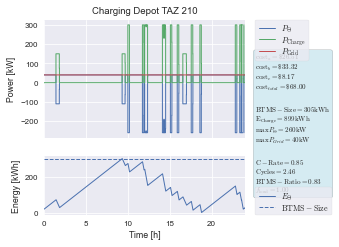

In [144]:
# plot result for paper
choosen_depot = '210'
for df in sizing_results:
    if df.name == choosen_depot:
        # use seaborn style
        #plt.style.use('seaborn')
        plt.style.use('seaborn-paper')
        pltSettings()
        plt.rcParams["mathtext.fontset"] = "cm"
        plt.rcParams["lines.linewidth"] = 1
        # box around legend
        plt.rcParams['legend.frameon'] = True
        fig, ax = plt.subplots(2,1, figsize=(10,10), sharex=True, gridspec_kw={'height_ratios': [2, 1]} )
        time_in_h = df['time']/3600
        stats_i = stats_sizing_function(df)

        btms_size = df['param: btms size, a,b,c'].iloc[0]

        ax[0].step(time_in_h, df['P_BTMS'], label=r'$P_\mathrm{\Theta}$')
        ax[0].step(time_in_h, df['P_Charge'], label=r'$P_{\mathrm{Charge}}$')
        ax[0].step(time_in_h, df['P_Grid'], label=r'$P_{\mathrm{Grid}}$')
        ax[0].set_title('Charging Depot TAZ ' + df.name)
        ax[0].set_ylabel('Power [kW]')
        # legend outside of plot
        ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., labelspacing=0)
        #ax[0].legend(loc = 'upper left')
        ax[1].plot(time_in_h, df['E_BTMS'] - df['E_BTMS'].min(), label=r'$E_\Theta$')
        ax[1].hlines(btms_size, 0, max(time_in_h), label=r'$\mathrm{BTMS-Size}$', linestyles='dashed')
        ax[1].set_ylabel('Energy [kWh]')
        ax[1].legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0., labelspacing=0)
        #ax[1].legend(loc = 'upper left')
        ax[1].set_xlabel('Time [h]')
        ax[1].set_xlim(0, max(time_in_h))

        # add text box with informations, costs and sizing results
        textstr1 = '\n'.join([
            r'$\mathrm{cost}_{a}= \$ %.2f$' % stats_i['cost_a'],
            r'$\mathrm{cost}_{b}= \$ %.2f$' % stats_i['cost_b'],
            r'$\mathrm{cost}_{c}= \$ %.2f$' % stats_i['cost_c'],
            r'$\mathrm{cost}_{total}= \$ %.2f$' % stats_i['cost_total'],])
        textstr2 = '\n'.join([
            '\n',
            r'$\mathrm{BTMS-Size} =%.0f \mathrm{kWh}$' % stats_i['btms_size'],
            r'$\mathrm{E}_\mathrm{Charge} =%.0f \mathrm{kWh}$' % stats_i['E_Charge'],
            r'$\max{P_{\Theta}}=%.0f \mathrm{kW}$' % df['P_BTMS'].abs().max(),
            r'$\max{P_{Grid}}=%.0f \mathrm{kW}$' % df['P_Grid'].max(),
            '\n',
            r'$\mathrm{C-Rate}= %.2f$' % stats_i['c_rate'],
            r'$\mathrm{Cycles}= %.2f$' % stats_i['cycles_day'],
            r'$\mathrm{BTMS-Ratio}= %.2f$' % stats_i['btms_ratio'],
            r'$f_\mathrm{load}= %.2f$' % stats_i['load_factor'],
            ])
        textstr = '\n'.join([
            textstr1, 
            textstr2])
        print(textstr)
        # reduce spacing between text with latex
        fig.set_size_inches(plotSizeX, 3*plotSizeY)
        # add text under legend of first plot
        props = dict(boxstyle='round', facecolor = 'lightblue', alpha=0.5)
        ax[0].text(1.05, 0.12, textstr, transform = ax[0].transAxes, fontsize = 7, bbox=props, va='center', ha='left', linespacing = 1, math_fontfamily='cm')

        plt.savefig(os.path.join(figure_directory, 'a_for_paper_trajectories' + df.name + '_btms_sizing.pdf'), dpi=300, bbox_inches='tight')

### stats analysis


In [145]:
stats_described = stats.describe()
# choose columns to keep
stats_described = stats_described[['share_cost_a', 'share_cost_b', 'share_cost_c', 'btms_size', 'E_Charge', 'c_rate', 'cycles_day', 'btms_ratio', 'load_factor']]
# choose rows to keep
stats_described = stats_described.loc[['mean', 'std', 'min', 'max']]
# rename columns
stats_described.columns = [r'$\frac{\text{cost}_\text{a}}{\text{cost}_\text{total}}$', r'$\frac{\text{cost}_\text{b}}{\text{cost}_\text{total}}$', r'$\frac{\text{cost}_\text{c}}{\text{cost}_\text{total}}$', r'BTMS-Size [\unit{\kWh}]', r'$E_\text{Charge}$ [\unit{\kWh}]', 'C-Rate', 'Cycles', 'BTMS-Ratio', r'$f_\text{load}$']
# rename rows
stats_described.index = ['$\mu$', '$\sigma$', '$\min$', '$\max$']
# round values
stats_described = stats_described.round(2)
# export to latex
stats_described.to_latex(os.path.join(result_directory, 'stats_step3_described.tex'), escape=False)
stats_described

,$\frac{\text{cost}_\text{a}}{\text{cost}_\text{total}}$,$\frac{\text{cost}_\text{b}}{\text{cost}_\text{total}}$,$\frac{\text{cost}_\text{c}}{\text{cost}_\text{total}}$,BTMS-Size [\unit{\kWh}],$E_\text{Charge}$ [\unit{\kWh}],C-Rate,Cycles,BTMS-Ratio,$f_\text{load}$
$\mu$,0.38,0.50,0.12,298.79,683.68,1.83,1.94,0.88,1.0
$\sigma$,0.02,0.01,0.01,152.65,441.61,0.91,0.49,0.07,0.0
$\min$,0.35,0.42,0.10,43.70,44.00,0.44,1.00,0.58,1.0
$\max$,0.48,0.52,0.15,1050.93,2957.17,6.82,3.68,0.99,1.0
